In [1]:
# Esse trecho verifica se o colab está usando CPU ou GPU.
# Se estiver como False ele está usando CPU, então mude pra GPU pra ele executar mais rápido
import torch

print("Status GPU:", torch.cuda.is_available())

Status GPU: True


In [2]:
# Instalando bibliotecas
!pip install transformers==4.44.0 torch scikit-learn matplotlib --quiet

# Preparando dos dados
import pandas as pd
from sklearn.model_selection import train_test_split

# Carregando dados da base que foi fornecida
sheet_url = "https://docs.google.com/spreadsheets/d/17aHYyRNfbmde8bVOR_HX_BmNUEdkygPuaGO4lJj26jg/export?format=csv"
df = pd.read_csv(sheet_url)

# Selecionando somente as colunas que vão ser utilizadas, nesse caso foram escolhidas a coluna onca, caseiro e notícia
df = df[['comment_text', 'onca', 'caseiro', 'notícia']].copy()

# Limpando dados
df['comment_text'] = df['comment_text'].astype(str).str.strip()
df = df[df['comment_text'] != ""]
df = df.dropna(subset=['comment_text'])
df = df.drop_duplicates(subset=['comment_text']).reset_index(drop=True)

# Mapeando
map_sent = {'negativo': 0, 'neutro': 1, 'positivo': 2}
map_noticia = {'ruim': 0, 'neutra': 1, 'boa': 2}

df['onca_label']    = df['onca'].map(map_sent)
df['caseiro_label'] = df['caseiro'].map(map_sent)
df['noticia_label'] = df['notícia'].map(map_noticia)

# Imprimindo
print(df[['onca', 'onca_label']].head())
print(df[['caseiro', 'caseiro_label']].head())
print(df[['notícia', 'noticia_label']].head())

# Salvando o csv que foi preparado (foi removido os textos vazios e duplicados e atribuido rotulos)
df.to_csv("/content/oncas_comentarios_rotulado.csv", index=False)
print("arquivo salvo")


     onca  onca_label
0  neutro           1
1  neutro           1
2  neutro           1
3  neutro           1
4  neutro           1
    caseiro  caseiro_label
0    neutro              1
1    neutro              1
2    neutro              1
3  negativo              0
4  negativo              0
  notícia  noticia_label
0  neutra              1
1     boa              2
2     boa              2
3  neutra              1
4  neutra              1
arquivo salvo


In [5]:
# Dividindo meus dados em treino / validação / teste (70% / 15% / 15%)

def split_data(df, target_col, test_size=0.15, val_size=0.15, random_state=42):

    X = df['comment_text'].values
    y = df[target_col].values

    # Separando teste (15%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Separando validação
    val_relative_size = val_size / (1 - test_size)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative_size, stratify=y_temp, random_state=random_state
    )

    print(f"treino: {len(X_train)}, validação: {len(X_val)}, teste: {len(X_test)}")
    return X_train, y_train, X_val, y_val, X_test, y_test

# Colunas utilizadas
targets = ['onca_label', 'caseiro_label', 'noticia_label']
# Variavel pra armazenar os splits
resultados = {}
for target in targets:
    print(f"\n coluna: {target}")
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, target)

    resultados[target] = {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val,     "y_val": y_val,
        "X_test": X_test,   "y_test": y_test
    }



 coluna: onca_label
treino: 3145, validação: 675, teste: 675

 coluna: caseiro_label
treino: 3145, validação: 675, teste: 675

 coluna: noticia_label
treino: 3145, validação: 675, teste: 675


In [6]:
# Tokenizando os textos e criando Dataset/DataLoader para o BERT

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Modelo utilizado para tokenização
MODEL_NAME = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 64  # tamanho máximo da sequência

# Dataset personalizado para preparar textos e rótulos
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenização (transforma texto em input_ids e attention_mask)
        encoded = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tamanho do lote
BATCH_SIZE = 4

# Criando os datasets com o split já realizado
train_dataset = CommentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset   = CommentDataset(X_val,   y_val,   tokenizer, MAX_LEN)
test_dataset  = CommentDataset(X_test,  y_test,  tokenizer, MAX_LEN)

# Criando DataLoaders usados no treino, validação e teste
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# 4. Modelo (BERT) + Treinamento
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

NUM_LABELS = 3  # negativo, neutro, positivo (ou ruim, neutra, boa)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)
model.to(device)

# Otimizador e scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 10
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss()


Device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Treino usando FP16 (autocast + GradScaler)
from torch.amp import autocast, GradScaler
scaler = GradScaler("cuda")

def train_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    for batch in data_loader:
        optimizer.zero_grad()

        # Enviando dados para GPU
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Treinando em FP16 para acelerar e economizar GPU
        with autocast("cuda"):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

        # Predições
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == labels).item()
        total_examples += labels.size(0)
        total_loss += loss.item()

        # Backpropagation em FP16
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Atualiza scheduler (se existir)
        if scheduler:
            scheduler.step()

    avg_loss = total_loss / len(data_loader)
    acc = total_correct / total_examples
    return avg_loss, acc


# Função de validação (sem gradiente)
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == labels).item()
            total_examples += labels.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    acc = total_correct / total_examples
    return avg_loss, acc


# Loop de treino (executa cada época)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc = eval_model(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"  Treino     - loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Validação  - loss: {val_loss:.4f}, acc: {val_acc:.4f}")

Epoch 1/10
  Treino     - loss: 0.3701, acc: 0.8884
  Validação  - loss: 0.2726, acc: 0.9096
Epoch 2/10
  Treino     - loss: 0.2195, acc: 0.9291
  Validação  - loss: 0.2430, acc: 0.9170
Epoch 3/10
  Treino     - loss: 0.1149, acc: 0.9653
  Validação  - loss: 0.2716, acc: 0.9067
Epoch 4/10
  Treino     - loss: 0.0478, acc: 0.9866
  Validação  - loss: 0.3155, acc: 0.9007
Epoch 5/10
  Treino     - loss: 0.0269, acc: 0.9933
  Validação  - loss: 0.3539, acc: 0.9081
Epoch 6/10
  Treino     - loss: 0.0183, acc: 0.9952
  Validação  - loss: 0.3747, acc: 0.9215
Epoch 7/10
  Treino     - loss: 0.0082, acc: 0.9978
  Validação  - loss: 0.4272, acc: 0.9156
Epoch 8/10
  Treino     - loss: 0.0030, acc: 0.9994
  Validação  - loss: 0.4380, acc: 0.9156
Epoch 9/10
  Treino     - loss: 0.0020, acc: 0.9997
  Validação  - loss: 0.4773, acc: 0.9141
Epoch 10/10
  Treino     - loss: 0.0011, acc: 1.0000
  Validação  - loss: 0.4755, acc: 0.9156


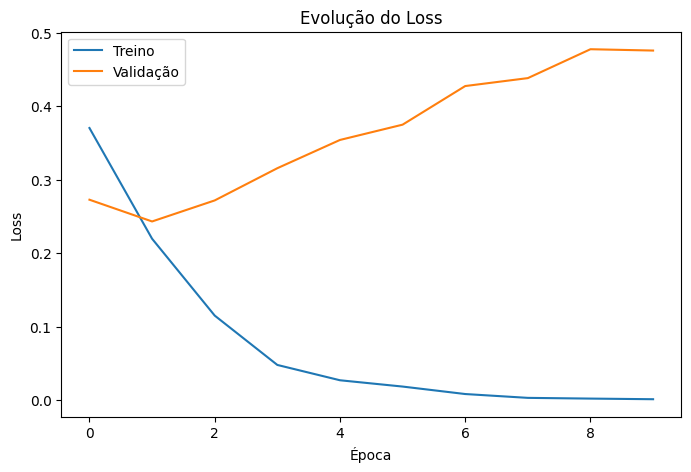

In [9]:
# Gráfico do loss (treino x validação)
plt.figure(figsize=(8,5))

# linha do loss de treino
plt.plot(train_losses, label='Treino')

# linha do loss de validação
plt.plot(val_losses, label='Validação')

plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução do Loss')
plt.legend()
plt.show()

In [10]:
# 5. Avaliação no conjunto de teste

# Relatório: precision, recall, F1
from sklearn.metrics import classification_report

# Função para obter predições do modelo
def get_predictions(model, data_loader, device):
    model.eval()                 # modo avaliação
    true_labels = []             # rótulos reais
    pred_labels = []             # rótulos previstos

    with torch.no_grad():        # sem gradiente
        for batch in data_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            # forward
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            # salvar valores
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(pred_labels)

# Pegando predições no dataset de teste
y_true_test, y_pred_test = get_predictions(model, test_loader, device)

# Nomes das classes (para onça e caseiro)
label_names = ['negativo', 'neutro', 'positivo']

# Mostrando o relatório
print(classification_report(y_true_test, y_pred_test, target_names=label_names, digits=4))

              precision    recall  f1-score   support

    negativo     0.7419    0.4259    0.5412        54
      neutro     0.9377    0.9832    0.9599       597
    positivo     0.7778    0.5833    0.6667        24

    accuracy                         0.9244       675
   macro avg     0.8191    0.6642    0.7226       675
weighted avg     0.9164    0.9244    0.9160       675



In [11]:
# 5.2. Mostrando exemplos de erros de classificação

# Textos do conjunto de teste
test_texts = X_test

erros = []

# Guardar apenas onde o modelo errou
for text, y_true, y_pred in zip(test_texts, y_true_test, y_pred_test):
    if y_true != y_pred:
        erros.append((text, int(y_true), int(y_pred)))

print(f"Total de erros no teste: {len(erros)}")

# Mostrar alguns exemplos (até 10)
map_idx_to_name = {0: 'negativo', 1: 'neutro', 2: 'positivo'}

for i, (text, y_t, y_p) in enumerate(erros[:10]):
    print("="*80)
    print("Texto:", text)
    print("Verdadeiro:", map_idx_to_name[y_t])
    print("Previsto  :", map_idx_to_name[y_p])

Total de erros no teste: 51
Texto: Essa I.A cheirou muito pó.💀
Verdadeiro: negativo
Previsto  : neutro
Texto: Nunca vi tanto sensualismo barato...
Verdadeiro: negativo
Previsto  : neutro
Texto: Muitas notícias fake estão se espalhando.
Verdadeiro: neutro
Previsto  : negativo
Texto: Você falou tudo meu amigo
Verdadeiro: positivo
Previsto  : neutro
Texto: Vcs que fizeram o vídeo, não teriam algo melhor para fazerem?Muita maldade com os familiares.
Verdadeiro: negativo
Previsto  : neutro
Texto: A onça era alimentada com frequência pelos barqueiros da região, que levavam turistas ao local, cobrando por isso. Isso está claro, quando diz que o animal não se intimida com a presença de pessoas. Infelizmente o ribeirinho foi a vítima (já anunciada pelo amigo) de uma atividade considerada ILEGAL e inconsequente. Que a polícia investigue o caso e prendam os barqueiros responsáveis.
Verdadeiro: positivo
Previsto  : neutro
Texto: Segundo falam que o caseiro estava deitado e distraído e não foi assi

In [12]:
# 5.3. (Opcional) Salvar previsões em CSV

# Criar DataFrame com textos + rótulos reais e previstos
result_df = pd.DataFrame({
    'comment_text': test_texts,
    'true_label': y_true_test,
    'pred_label': y_pred_test
})

# Adicionar nomes das classes (em vez dos números)
result_df['true_label_nome'] = result_df['true_label'].map(map_idx_to_name)
result_df['pred_label_nome'] = result_df['pred_label'].map(map_idx_to_name)

# Salvar o arquivo
result_df.to_csv("/content/drive/MyDrive/Colab Notebooks/resultados_onca_teste.csv", index=False)
print("Resultados de teste salvos em resultados_onca_teste.csv")


Resultados de teste salvos em resultados_onca_teste.csv
